In [1]:
import numpy as np
import pandas as pd
import operator
import matplotlib.pyplot as plt
import datetime 
import xgboost as xg
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.decomposition import PCA

import sys
sys.path.insert(1, 'D:/TMU/thesis/codes')

from package.featureSelection_SICE import *
from package.loadDb import *

In [2]:
# data with target column
address = "..\database\stock market dataset"
data_with_target=load_stock_market_dataframe(address+"\sample_normalized_with_target.csv")
data_with_target=data_with_target.iloc[60000:80000]

# data_without_target=data_with_target.iloc[:,:-1]
target=data_with_target.iloc[:,-1]
# ..............................................
# address = "..\database\kaggleDataFrame"
# data_with_target= load_kaggle_dataframe(address+"\dataframes.csv")
# # data_with_target=data_with_target.iloc[:15]

# data_without_target = data_with_target.drop(['DEMAND'],axis=1)

# target=data_with_target.iloc[:,-1]
# ..............................................
print("data with target size = ",data_with_target.shape )

# X_pca=compute_pca(data_without_target,num_comp=None)

data with target size =  (20000, 77)


In [3]:
num_features=data_with_target.shape[1]

num_comp=13
# window_size=10
interval = 2000
testSize=500

number of windows= 1000 
size of windows = 2
[1.7153970466926531, 1.7153862428207765, 0.7386855970404733, 0.02635425894942969, 1.5683272376372455, 1.7153968051355593, 1.7153968443913101, 1.715396954674909, 1.7153969546417112, 1.7153969532081192, 1.715396931515848, 1.7153970353739942, 1.715396959594939, 1.7153970082209857, 1.6077271299633584, 1.5154615274930905, 1.4352737797108654, 0.10600643172814178, 0.6574032323152126, 1.6027037402519677, 1.1989448241948728, 0.08157139647537773, 1.6630792521579842, 0.8165665566015204, 1.430288920417698, 0.10516975110272353, 1.6082899001371322, 1.5212889321750365, 1.2846952726165324, 1.3759732595489684, 1.27698332882801, 0.15821794010782658, 0.9498492048354457, 1.3706686424622236, 1.5465160929536719, 0.6826752814282483, 0.026667112159144468, 1.3461721404158782, 0.05284283005352997, 0.6594688555025281, 1.7153970466926618, 1.6891428630645562, 1.715397046692686, 0.5001849890720651, 0.813086470977247, 1.5456046761751059, 1.1544099773453407, 1.422313613470

<AxesSubplot: title={'center': 'num_comp=13'}>

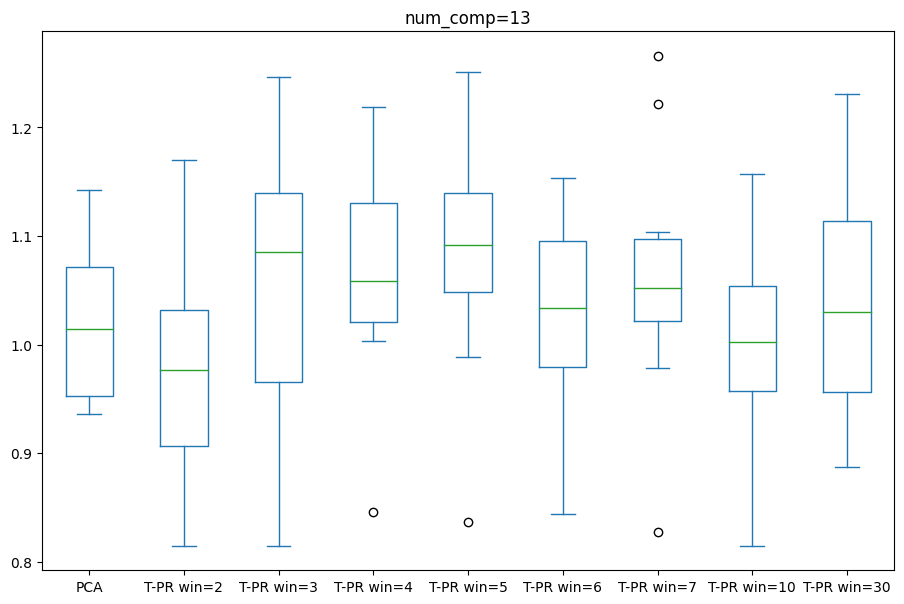

In [5]:
counter=0
pca_list=[]
dict={}

while counter+interval <= data_with_target.shape[0]:


    datacut=data_with_target[counter:counter+interval]
    X_datacut=datacut.iloc[:,:-1]
    Y_datacut=datacut.iloc[:,-1]
    # print(counter,X_datacut.shape)
    X_pca=compute_pca(X_datacut,num_comp=num_comp)

    pca_mse=xgboost_reg_error(X_pca,Y_datacut,testSize)
    pca_list.append(pca_mse)##########################
    counter+=interval
dict['PCA']=pca_list

    
for window_size in [2,3,4,5,6,7,10,30]:
    method_list = []
    counter=0

    while counter+interval <= data_with_target.shape[0]:


        datacut=data_with_target[counter:counter+interval]
        X_datacut=datacut.iloc[:,:-1]
        Y_datacut=datacut.iloc[:,-1]

        selected_features_index=featureSelection(X_datacut,window_size)
        selected_data= X_datacut[X_datacut.columns[selected_features_index]].to_numpy()
        mse=xgboost_reg_error(selected_data[:,:num_comp],Y_datacut,testSize)
        

        method_list.append(mse)
        #     print( "method_list",method_list)
        print(counter/interval)
        print("----------------------------------------------------------------------------")
        counter+=interval
    dict["SICE win={}".format(window_size)]=method_list
    
dataframe = pd.DataFrame(dict)
plt.rcParams["figure.figsize"] = [11,7]
dataframe.plot(kind="box",title="num_comp={}".format(num_comp))

In [6]:
display(dataframe)

,PCA,T-PR win=2,T-PR win=3,T-PR win=4,T-PR win=5,T-PR win=6,T-PR win=7,T-PR win=10,T-PR win=30
0,0.935763,0.814740,0.814740,1.018346,1.041623,1.041950,0.978911,0.814740,0.966544
1,1.074786,1.045953,0.959249,1.003224,1.078260,1.025872,1.042970,1.048572,1.022740
2,0.939151,0.869669,0.844467,0.845703,0.836216,0.843590,0.827555,0.844467,0.926260
3,0.943899,0.986417,0.986318,1.029103,1.070414,0.882025,1.021390,0.953501,0.952942
4,0.980033,0.988546,1.054833,1.061485,0.988546,1.033459,1.061485,1.055928,1.037549
5,1.073895,0.967742,1.168376,1.056390,1.105751,1.153731,1.077336,0.967742,1.069846
6,1.142312,1.170461,1.141576,1.219226,1.141576,1.147882,1.221818,0.995071,1.174516
7,1.063989,0.963333,1.246099,1.126430,1.251426,0.963333,1.266008,1.157411,1.230714
8,0.988470,0.887281,1.114910,1.197962,1.135546,1.034521,1.024583,1.009457,0.887281
9,1.039952,1.104231,1.134172,1.132322,1.163196,1.113746,1.103895,1.083365,1.128835


In [7]:
df=pd.DataFrame(columns=dataframe.columns)
df.loc['Var'] =list(dataframe.var())
df.loc['Mean'] =list(dataframe.mean())
df.loc['Min'] =list(dataframe.min())
df.loc['Max'] =list(dataframe.max())

In [8]:
df

,PCA,T-PR win=2,T-PR win=3,T-PR win=4,T-PR win=5,T-PR win=6,T-PR win=7,T-PR win=10,T-PR win=30
Var,0.005020,0.011631,0.020215,0.011674,0.012577,0.010794,0.014936,0.010951,0.012532
Mean,1.018225,0.979837,1.046474,1.069019,1.081255,1.024011,1.062595,0.993026,1.039723
Min,0.935763,0.814740,0.814740,0.845703,0.836216,0.843590,0.827555,0.814740,0.887281
Max,1.142312,1.170461,1.246099,1.219226,1.251426,1.153731,1.266008,1.157411,1.230714


<AxesSubplot: >

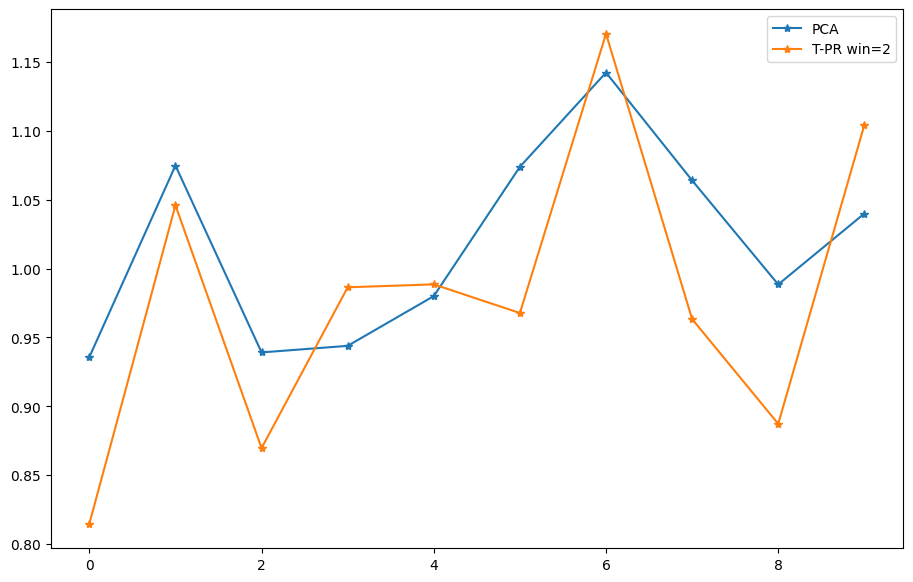

In [10]:
dataframe.iloc[:,[0,1]].plot(kind='line', marker='*')

In [ ]:
window_size=50
testSize=500
# num_comp=1

In [ ]:
num_comp=1
pca_list=[]
fselection_list = []


selected_features_index=featureSelection(data_without_target,window_size)
selected_data= data_without_target[data_without_target.columns[selected_features_index]].to_numpy()
# print(np.array(selected_features_index)+1)

while data_without_target.shape[1] >= num_comp:
    rmse_fselection=xgboost_reg_error(selected_data[:,:num_comp],target,testSize)
    rmse_pca=xgboost_reg_error(X_pca[:,:num_comp],target,testSize)
    
    pca_list.append(rmse_pca)
    fselection_list.append(rmse_fselection)
    num_comp=num_comp+1
    
print ("RMSE of f_s model is",np.array(fselection_list).round( decimals=2))
print ("RMSE of pca model is",np.array(pca_list).round( decimals=2))

t = np.arange(len(fselection_list))
t.shape
fig, ax = plt.subplots()
ax.plot(t,fselection_list,marker="*", label='our method')

# Plot another line on the same chart/graph
ax.plot(t, pca_list,marker="*", label='PCA method')
legend = ax.legend(loc='upper left', shadow=True, fontsize='large')
plt.show()

number of windows= 939 
size of windows = 50
[1.9027767316870186, 1.9027846081435031, 1.9027435732464006, 1.9027675799566466, 1.8860856989513322, 1.8474405857047391, 1.899095019480789, 1.8987337706172156, 1.9017318664129998, 1.9035522249751913]
[10  2  1  4  3  9  7  8  5  6]
RMSE of f_s model is [0.15 0.11 0.09 0.09 0.09 0.09 0.09 0.08 0.09 0.09]
RMSE of pca model is [0.09 0.09 0.09 0.09 0.09 0.08 0.08 0.09 0.08 0.09]


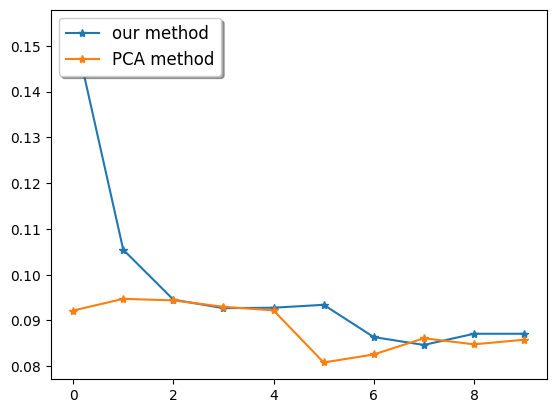